<a href="https://colab.research.google.com/github/silasabs/CoherentOptics/blob/main/Jupyter/Equalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from optic.comm.modulation import modulateGray
from optic.dsp.core import pnorm, upsample, firFilter, pulseShape, signal_power, phaseNoise, decimate, resample, symbolSync
from optic.dsp.equalization import edc
from optic.models.devices import iqm, coherentReceiver
from optic.models.channels import linearFiberChannel
from optic.comm.metrics import fastBERcalc
from optic.utils import parameters, dBm2W
from optic.plot import pconst, eyediagram

# Equalização

Neste notebook iremos explorar os próximos blocos na cadeia de algoritmos DSP que são dois equalizadores lineares que compensam os efeitos da dispersão cromática (CD) e da dispersão do modo de polarização (PMD) que são implementados na maioria dos receptores ópticos digitais coerentes.

Em sistemas ópticos digitais coerentes, a compensação CD é completamente deixada para o domínio digital. As vantagens dessa escolha são diversas, como a redução das perdas de inserção causadas pelos módulos ópticos de compensação de CD e a facilitação do projeto e gerenciamento do sistema. 

#### Equalização estática - Compensação CD:

Nos receptores ópticos digitais coerentes, o CD é compensado por filtros estáticos aplicados separadamente aos sinais das duas orientações de polarização. Como CD é praticamente invariante no tempo e independente da polarização, os filtros correspondentes às duas orientações de polarização possuem os mesmos coeficientes.

#### Equalização adaptativa - Compensação PMD:

Ao contrário da abordagem estática usada para compensação CD, a compensação PMD requer equalizadores que sejam capazes de atualizar adaptativamente seus coeficientes para rastrear variações na resposta de frequência do canal, causadas por perturbações mecânicas na geometria da fibra ou oscilações de temperatura. Além disso, como os canais de polarização se acoplam durante a transmissão por fibra, são necessárias arquiteturas com múltiplas entradas e múltiplas saídas (MIMO). Como benefício colateral, a equalização adaptativa também compensa efeitos lineares residuais, como o CD que sobrou do equalizador estático ou filtragem de banda estreita em interruptores seletivos de comprimento de onda.

### 5.1 Static Equalization

O módulo de compensação CD é o primeiro a ser implementado no receptor após o front-end e a compensação de suas imperfeições. Como o CD se comporta bem no tempo e afeta igualmente ambas as orientações de polarização, os filtros de compensação CD são estáticos, ou seja, seus coeficientes não variam com o tempo. As questões mais relevantes da compensação CD estão relacionadas com a implementação do hardware e a sua complexidade e consumo de energia.

A primeira tarefa para implementar filtros de compensação CD é dimensionar seus parâmetros levando em consideração as propriedades do canal óptico. Naturalmente, o design do equalizador está diretamente relacionado à propagação do atraso do canal. Uma aproximação para o *delay spread* do CD é dada por: 

$$\Delta T=|D|L\Delta\lambda=2\pi|\beta_{2}|L\Delta_{f}$$

onde $D$ é o parâmetro de dispersão da velocidade de grupo (GVD), $L$ é o comprimento da fibra, $\Delta \lambda$ e $\Delta f$ são as larguras de banda espectrais em comprimento de onda e frequência, e $\beta_{2}$ é a segunda derivada da constante de propagação $\beta$ em relação à frequência angular $\omega$. Se o sinal recebido for amostrado a uma taxa de amostragem $T_{Sa}$ (período de amostragem), o *delay spread* no número de amostras é dado por:

$$N_{\mathrm{DS}}=\left[\frac{\Delta T}{T_{S a}}\right]=\left[\frac{2\pi\,|\beta_{2}|L\,\Delta f}{T_{S a}}\,\right]$$

Assumindo modelagem de pulso de Nyquist com largura de banda mínima ($\Delta f\,\approx\,R_{s}$) e uma taxa de sobreamostragem $M/K\ (T_{S a}=K/(M R_{S}))$, então:

$$N_{\mathrm{DS}}\approx\left[2\pi|\beta_{2}|L R_{s}^{2}(M/K)\right]$$

Esperamos que o comprimento mínimo do equalizador CD seja proporcional ao $N_{DS}$, mas o valor exato depende de muitos aspectos, particularmente da forma do pulso e do filtro anti-aliasing. Uma expressão empírica para esse comprimento mínimo, validada para diversos formatos de pulso, é apresentado como:

$$N_{\mathrm{CD}}\approx\left[6.67|\beta_{2}|L R_{s}^{2}(M/K)\right]$$

### 5.1.1 Equalização no domínio da frequência

A depender das características do link o equalizador CD pode ter centenas ou milhares de *taps*, dependendo da taxa de amostragem e comprimento do link. Portanto, a equalização no domínio da frequência é geralmente preferida para reduzir a complexidade. Assumindo uma frequência de Nyquist $f_{N}\,=\,1/(2T_{S a})$, os coeficientes de um equalizador CD no domínio da frequência de tamanho NFFT são facilmente obtidos a partir da resposta de frequência CD dada por:

$$H_{\mathrm{CD}}[n]=e^{-j\frac{\pi\lambda^{2}D L}{c}\Big(n\frac{2f_{N}}{N_{\mathrm{FFT}}}\Big)^{2}},\ \ \ -\frac{N_{\mathrm{FFT}}}{2}\le n\le\ \frac{N_{\mathrm{FFT}}}{2}-1$$

In [3]:
def freqHCD(Fc, Fs, D, NFFT, L):
    # parâmetros de comprimento de onda e velocidade da luz no vacuum
    c = 299792458
    λ = c/Fc
    beta2 = -(D * λ**2) / (2 * np.pi * c)

    omega = 2 * np.pi * Fs * np.fft.fftfreq(NFFT)

    #Tsa = 1/oversampling*1/Rs
    return np.exp(-1j * beta2/2 * omega**2 * L)

### Respostas de magnitude e fase de um filtro de compensação de dispersão $H_{CD}[n]$

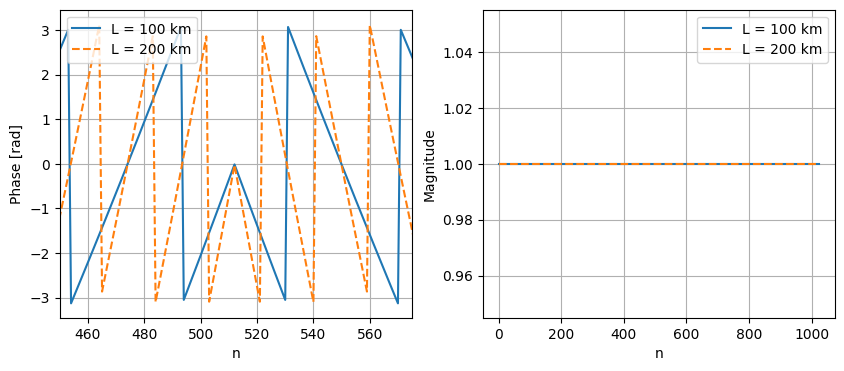

In [219]:
NFFT = 1024     # comprimento do filtro
Rs   = 32e9     # taxa de símbolos
D    = 17e-6    # parâmetro de dispersão ps/(nm*km)
SpS  = 2        # amostras por símbolo
Fc   = 193.1e12
Fs   = SpS*Rs

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(np.angle(freqHCD(Fc, Fs, D, NFFT, L=100e3)), label='L = 100 km')
axs[0].plot(np.angle(freqHCD(Fc, Fs, D, NFFT, L=200e3)), '--', label='L = 200 km')
axs[0].set_xlim(450, 575)
axs[0].set_ylabel('Phase [rad]')
axs[0].set_xlabel('n')
axs[0].legend()
axs[0].grid()

axs[1].plot(np.abs(freqHCD(Fc, Fs, D, NFFT, L=100e3)), label='L = 100 km')
axs[1].plot(np.abs(freqHCD(Fc, Fs, D, NFFT, L=200e3)), '--', label='L = 200 km')
#axs[1].set_xlim(-NFFT/2, NFFT/2)
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('n')
axs[1].legend()
axs[1].grid()

Como esperado, o diagrama de amplitude é constante, indicando um filtro passa-tudo, enquanto o diagrama de fases mostra um perfil parabólico. Quanto maior for a dispersão acumulada, mais íngreme será o perfil parabólico. 

Uma dificuldade na implementação da compensação CD no domínio da frequência é que a equalização é realizada em blocos. Quando a equalização é realizada em blocos individuais, não é possível cancelar a interferência intersimbólica (ISI) nas bordas do bloco. Além disso, a equalização no domínio da frequência envolve o cálculo da transformada discreta de Fourier (DFT) do bloco, a multiplicação pelos coeficientes do filtro e o cálculo da transformada discreta inversa de Fourier (IDFT), geralmente implementada por transformadas rápidas (inversas) de Fourier (FFTs/IFFTs). 

Este processo corresponde a uma convolução cíclica do bloco de sinal pelos coeficientes do filtro, o que causa aliasing no tempo. A recuperação da convolução linear da sequência recebida pelos coeficientes do filtro, a partir da convolução cíclica em blocos, pode ser alcançada de duas maneiras.

A primeira é inserir intervalos de guarda ou prefixos cíclicos entre os blocos, o que desperdiça largura de banda de transmissão. A segunda solução são os métodos de *overlap* e adição de *overlap*, que não consomem largura de banda, mas aumentam a complexidade do DSP. Em sistemas de comunicação óptica, os métodos baseados em *overlap* são geralmente preferidos. 

### Método Overlap-Save

<br>
<center>
    <img src="https://i.postimg.cc/QC1yzz31/Screenshot-from-2024-04-22-18-59-51.png">
</center>
<br>

O método *overlap-save* é descrito na figura acima. Uma sequência de amostras entra continuamente no receptor. Esta sequência é dividida em blocos de igual comprimento para processamento no domínio da frequência, de tal forma que o bloco $I_n$ se sobrepõe aos blocos $I_{n−1}$ e $I_{n+1}$. Após a FFT, multiplicação por coeficientes do filtro, e IFFT, o bloco de saída $O_n$ é obtido. Se $I_n$ for equalizado independentemente, o ISI gerado pelos os símbolos vizinhos nas bordas de $O_n$ ficam sem compensação e a convolução cíclica causa aliasing no tempo. Portanto, a sequência de saída é recuperada preservando a porção central de $O_n$ e descartando suas arestas. Esta abordagem é repetida sequencialmente de forma a evitar qualquer perda de informação.

O método *overlap-save* têm dois parâmetros importantes, o tamanho da FFT, $N_{FFT}$, e o tamanho do *overlap*, $N_{Overlap}$. O valor mínimo de $N_{Overlap}$ é dado pelo comprimento mínimo do equalizador ($N_{CD}$), enquanto o NFFT é normalmente ajustado para minimizar a complexidade. O número de multiplicações por símbolo exigidas pelos métodos de *overlap* vista em [2] pode ser calculado como:

$$N_{\mathrm{mult}}=\frac{N_{\mathrm{FFT}}\left[6\cdot C\cdot1\mathrm{og}_{2}(N_{\mathrm{FFT}})+3\right]}{N_{\mathrm{FFT}}-N_{\mathrm{Overlap}}+1}$$

Onde $C$ é uma constante relacionada à implementação da FFT. Para implementações de base 2 (tamanho de FFT igual a uma potência de 2) $C = 1/2$, e para implementações de base 4 (tamanho de FFT igual a uma potência de 4) $C = 3/8$.

In [267]:
def next_power_of_2(n):
    return 1 << (int(np.log2(n - 1)) + 1)

def fft_convolution(x, h):
    # Tamanho da saída
    Ny = x.shape[0] + h.shape[0] - 1 

    # Calcule as transformadas rápidas de Fourier
    # dos sinais no domínio do tempo
    X = np.fft.fft(x)
    H = np.fft.fft(h)

    # Realiza a convolução circular no domínio da frequência
    Y = X * H

    # Volta ao domínio do tempo
    y = np.fft.ifft(Y)

    # Corte o sinal para o comprimento de saida esperado
    return y[:Ny]

In [268]:
def overlap_save_convolution(x, h, B, NFFT=None):
    """ Convolução Overlap-Save de x e h com comprimento de bloco B
        
        input:
            x np.array: signal de entrada.
            h np.array: coeficientes do filtro.
            B int: comprimento do bloco.
            NFFT int: comprimento do filtro.
        output:
            y np.array: sinal convoluído.
    """

    M = len(x)
    N = len(h)

    if NFFT is None:
        NFFT = max(B, next_power_of_2(N))
        
    # Determina o número de blocos de entrada
    num_input_blocks = np.ceil(M / B).astype(int) \
                     + np.ceil(NFFT / B).astype(int) - 1

    # realiza o zero padding ao sinal x para um múltiplo inteiro de B
    xp = np.pad(x, (0, num_input_blocks*B - M), mode='constant', constant_values=0+0j)

    output_size = num_input_blocks * B + N - 1
    y = np.zeros((output_size,), dtype="complex")
    
    # Buffer de entrada
    xw = np.zeros((NFFT,), dtype="complex")

    # Convolução de todos os blocos
    for n in range(num_input_blocks):
        # Extraia o enésimo bloco de entrada
        xb = xp[n*B:n*B+B]

        # Janela deslizante da entrada
        xw = np.roll(xw, -B)
        xw[-B:] = xb

        # Convolução rápida por FFT
        u = fft_convolution(xw, h)

        # Salve as amostras de saída válidas
        y[n*B:n*B+B] = u[-B:]

    y = y[:M+N-1]
    
    # Remove o atraso do filtro FIR
    start = (N - 1) // 2
    return y[start:start+M]

### Transmissor
**geração de sinal de polarização única**

In [269]:
# Transmitter parameters
M = 16                  # Ordem da modulação
constType = 'qam'       # Esquema de modulação
pulseType = 'rrc'       # Pulso a ser utilizado
Rs = 10e9               # Taxa de símbolos [símbolo/s]
Ts = 1/Rs               # Período de símbolo em segundos
SpS = 32                # Amostras por símbolo
Fa = 1/(Ts/SpS)         # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa               # Período de amostragem
Ncoeff = 1024           # Número de coeficientes do filtro RC
alpha = 0.05            # Rolloff

# parâmetros do IQM
paramIQM = parameters()
paramIQM.Vπ = 2 
paramIQM.Vb = -paramIQM.Vπ

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# Parâmetros da fibra
paramFiber = parameters()
paramFiber.L = 100          # comprimento do enlace [km]
paramFiber.alpha = 0        # coeficiente de perdas [dB/Km]
paramFiber.D = 17           # parâmetro de dispersão [ps/nm/km]
paramFiber.Fs = Fa          # Frequência de amostragem do sinal [amostras/segundo]
paramFiber.Fc = 193.1e12    # Hz

### Core simulation

Potência média do sinal óptico modulado [mW]: 1.190 mW
Potência média do sinal óptico modulado [dBm]: 0.756 dBm


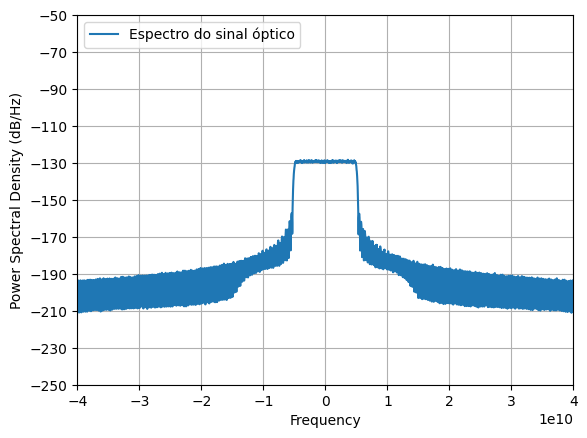

In [270]:
plotPSD = True

# gera uma sequência de bits pseudo-aleatórios que chegam ao transmissor
bitsTx = np.random.randint(2, size = int(1e5*np.log2(M)))

symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # symbol power normalization

symbolsUp = upsample(symbTx, SpS)

if pulseType == "nrz" or pulseType == "rect":
    pulse = pulseShape(pulseType, SpS)
elif pulseType == "rrc":
    pulse = pulseShape("rrc", SpS, Ncoeff, alpha, Ts)

pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = iqm(Ai, 0.1*paramIQM.Vπ*sigTx, paramIQM)

print('Potência média do sinal óptico modulado [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modulado [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

# plota psd
if plotPSD:
    plt.figure();
    plt.ylim(-250,-50);
    plt.psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
    plt.legend(loc='upper left');
    plt.xlim(-4*Rs,4*Rs);

### Simula um front-end do receptor coerente sujeito a ruído de fase do laser

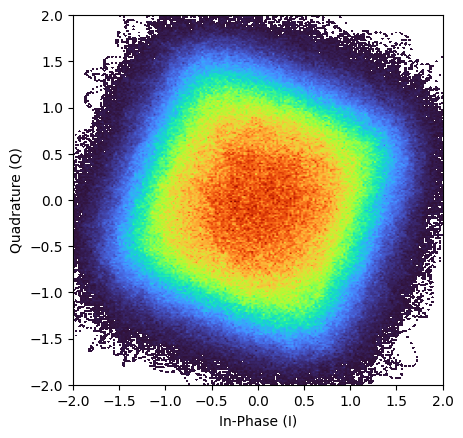

In [271]:
# canal óptico linear
sigRxo = linearFiberChannel(sigTxo, paramFiber)

# parâmetros do receptor
B = 10e9            # banda do receptor em Hz
Plo_dBm  = 10       # potência do oscilador local
Δf_lo    = 0        # desvio de frequência do oscilador local
ϕ_lo     = 0        # fase do oscilador local
lw       = 100      # laser linewidth Hz

Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor

# oscilador local
t = np.arange(0, sigRxo.size)*Ta
ϕ_pn_lo  = phaseNoise(lw, sigRxo.size, Ta)

sigLO = np.sqrt(Plo)*np.exp(1j*(2*np.pi*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# sinal na saída do front-end do receptor coerente
sigRx_ = coherentReceiver(sigRxo, sigLO)
pconst(sigRx_, R = 2);

### Efeito da dispersão 

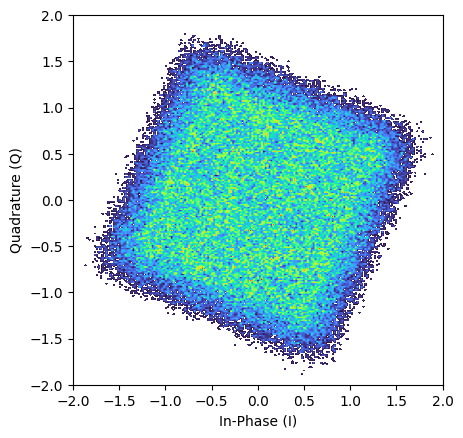

In [272]:
sigRx_visualize = firFilter(pulse, sigRx_)

# captura amostras no meio dos intervalos de sinalização
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1
sigRx_visualize = decimate(sigRx_visualize.reshape(-1,1), paramDec).reshape(-1,)

discard = 2000
ind = np.arange(discard, sigRx_visualize.size-discard)

sigRx_visualize = pnorm(sigRx_visualize)
pconst(sigRx_visualize, R=2);

### Compensa a dispersão cromática

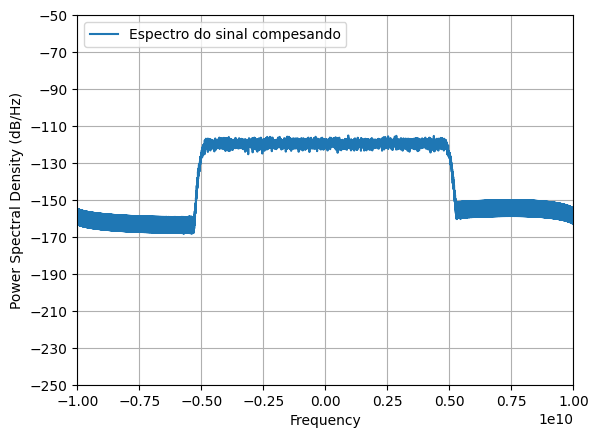

In [273]:
# filtro casado
sigRx = firFilter(pulse, sigRx_)

NFFT = 4096
HCD  = freqHCD(paramFiber.Fc, 2*Rs, paramFiber.D*1e-6, NFFT, paramFiber.L*1e3)

paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 2
sigRxEDCin = decimate(sigRx.reshape(-1,1), paramDec).reshape(-1,)

# Compensa dispersão cromática
sigRxEDCout = overlap_save_convolution(sigRxEDCin, np.fft.ifft(HCD), NFFT//2, NFFT)

plt.figure();
plt.ylim(-250,-50);
plt.psd(sigRxEDCout, Fs=2*Rs, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal compesando')
plt.legend(loc='upper left');
plt.xlim(-Rs,Rs);

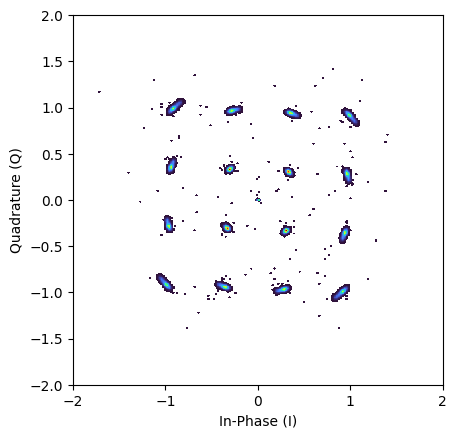

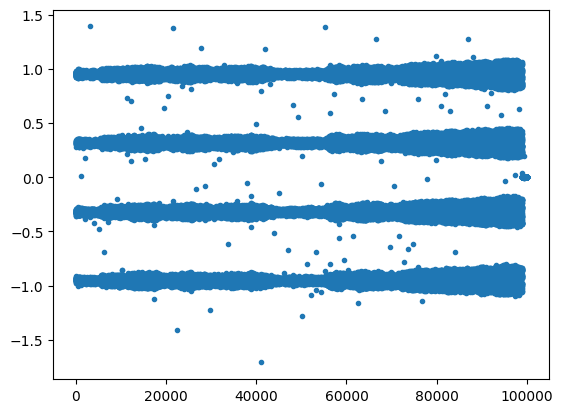

In [274]:
# captura amostras no meio dos intervalos de sinalização
paramDec = parameters()
paramDec.SpS_in = 2
paramDec.SpS_out = 1
sigRxEDCout = decimate(sigRxEDCout.reshape(-1,1), paramDec).reshape(-1,)

discard = 400
ind = np.arange(discard, sigRxEDCout.size-discard)

sigRxEDCout = pnorm(sigRxEDCout)
pconst(sigRxEDCout, R=2);

plt.figure()
plt.plot(sigRxEDCout.real,'.')

$$N_{\mathrm{CD}}\approx\left[6.67|\beta_{2}|L R_{s}^{2}(M/K)\right]$$

In [275]:
beta2 = -(paramFiber.D * 299792458/paramFiber.Fc**2) / (2 * np.pi * 299792458)
N = 6.67*np.abs(beta2)*paramFiber.L*1e3*Rs**2
N

0.004839832587068469

# Referências

[1] Digital Coherent Optical Systems, Architecture and Algorithms

[[2]](https://arxiv.org/pdf/1603.00734.pdf) T. Xu, G. Jacobsen, S. Popov, M. Forzati, J. Mårtensson, M. Mussolin, J. Li, K. Wang, Y. Zhang, A.T. Friberg, Frequency-domain chromatic dispersion equalization using overlap-add methods in coherent optical system. J. Opt. Commun. 32(2), 131–135 (2011)